In [2]:
from src.visualisation import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.svm import LinearSVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import glob
import copy
import torch
import pandas as pd

from hvs_hsi_pytorch.utils import hsi_utils, utils
from hvs_hsi_pytorch.hs_image import HSImage

In [3]:
# Read HSI image data
img_files = glob.glob("data/finger_data/session_001/P010001_V03_iHSI_T01_2022-07-28-16-16-54/raw/*")
n_files, i_files = len(img_files), 0
for i in range(len(img_files)):
    print(('[*]' if i == i_files or i == n_files + i_files else '[ ]') + '\t%s' % (img_files[i].split('/')[-1]))

img_path = img_files[i_files]
white_path = "data/finger_data/session_001/exported_white_2022-07-15-20-29-45.png"

img = hsi_utils.load_frame(img_path)
white = hsi_utils.load_sample(white_path)

hsi_data = HSImage(array=img, wavelengths=None, camera="imec 4x4-VIS-15.7.15.4")
hsi_data.reconstruct(white=white, dark=None, rho=15, method="flatfield")
hsi_origin = copy.deepcopy(hsi_data)
hsi_data.array = utils.normalise_L1(hsi_data.array)

data = hsi_data.array
shape = data.shape
data = data.reshape(shape[0], shape[1] * shape[2]).swapaxes(0, 1)

[*]	frame_000106_raw.png
[ ]	frame_000116_raw.png
[ ]	frame_000191_raw.png
[ ]	frame_000181_raw.png
[ ]	frame_000131_raw.png
[ ]	frame_000121_raw.png
[ ]	frame_000141_raw.png
[ ]	frame_000151_raw.png
[ ]	frame_000091_raw.png
[ ]	frame_000176_raw.png
[ ]	frame_000166_raw.png
[ ]	frame_000101_raw.png
[ ]	frame_000111_raw.png
[ ]	frame_000136_raw.png
[ ]	frame_000126_raw.png
[ ]	frame_000196_raw.png
[ ]	frame_000186_raw.png
[ ]	frame_000146_raw.png
[ ]	frame_000156_raw.png
[ ]	frame_000171_raw.png
[ ]	frame_000161_raw.png
[ ]	frame_000096_raw.png
[ ]	frame_000000_raw.png


In [5]:
# Read reformatted dataset
path = ["data/mc/colon_train_15.7.15.4_norm_l1.csv",
        "data/mc/generic_train_15.7.15.4_power_led_300.csv",
        "data/mc/generic_train_15.7.15.4_norm_l1.csv",
        "data/mc/generic_train_15.7.15.4_power_led_300_norm_l1.csv",
        "data/mc/generic_train_reformatted.csv"]

i_path = 3
data_df = pd.read_csv(path[i_path])
data_df = data_df.sample(n=10000)
# print(data_df.columns)

target = 0
n_spectrum_start = 24
n_train = int(len(data_df) * 0.8)

train_df = data_df[:n_train]
valid_df = data_df[n_train:]

selected_columns = []
for param in ['sao2', 'vhb']:
    selected_columns += [i for i, j in enumerate(train_df.columns) if j.find(param) != -1]

/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


<Figure size 432x288 with 0 Axes>

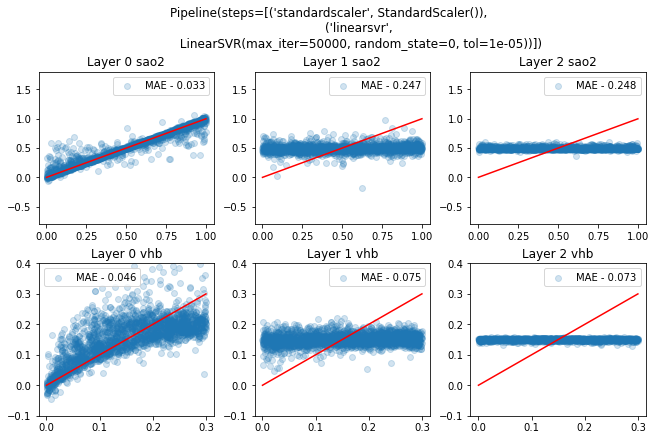

In [6]:
plt.figure()
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(9, 6))
axs = axs.flatten()
regressor = None

for i in range(6):
    train_x = train_df.iloc[:, n_spectrum_start:]
    train_y = train_df.iloc[:, selected_columns[i]]

    valid_x = valid_df.iloc[:, n_spectrum_start:]
    valid_y = valid_df.iloc[:, selected_columns[i]]

    regressor = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, max_iter=50000))

    regressor.fit(train_x, train_y)
    pred_y = regressor.predict(valid_x)

    label = 'MAE - %.3f' % mean_absolute_error(valid_y, pred_y)
    tissu_type = 'sao2' if i // 3 == 0 else 'vhb'
    title = 'Layer ' + str(i % 3) + ' ' + tissu_type
    aim_range = [-0.8, 1.8] if i // 3 == 0 else [-0.1, 0.4]
    plot_valid_each(axs[i], valid_y, pred_y, title=title, label=label, aim_range=aim_range)

fig.suptitle(str(regressor))
plt.show()

<Figure size 432x288 with 0 Axes>

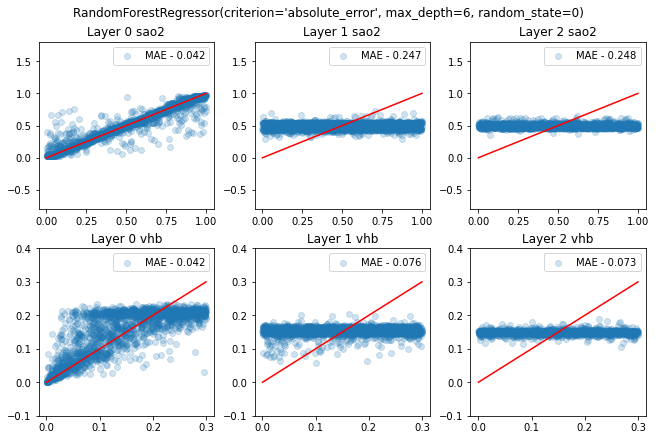

In [7]:
plt.figure()
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(9, 6))
axs = axs.flatten()
regressor = None

for i in range(6):
    train_x = train_df.iloc[:, n_spectrum_start:]
    train_y = train_df.iloc[:, selected_columns[i]]

    valid_x = valid_df.iloc[:, n_spectrum_start:]
    valid_y = valid_df.iloc[:, selected_columns[i]]

    regressor = RandomForestRegressor(max_depth=6, random_state=0, criterion='absolute_error')

    regressor.fit(train_x, train_y)
    pred_y = regressor.predict(valid_x)

    label = 'MAE - %.3f' % mean_absolute_error(valid_y, pred_y)
    tissu_type = 'sao2' if i // 3 == 0 else 'vhb'
    title = 'Layer ' + str(i % 3) + ' ' + tissu_type
    aim_range = [-0.8, 1.8] if i // 3 == 0 else [-0.1, 0.4]
    plot_valid_each(axs[i], valid_y, pred_y, title=title, label=label, aim_range=aim_range)

fig.suptitle(str(regressor))
plt.show()

<Figure size 432x288 with 0 Axes>

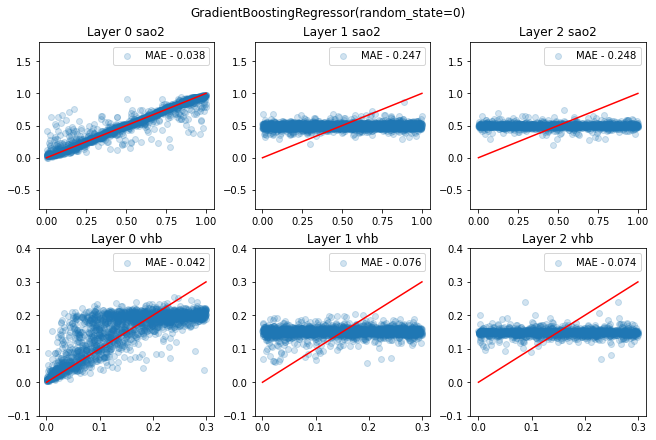

In [8]:
plt.figure()
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(9, 6))
axs = axs.flatten()
regressor = None

for i in range(6):
    train_x = train_df.iloc[:, n_spectrum_start:]
    train_y = train_df.iloc[:, selected_columns[i]]

    valid_x = valid_df.iloc[:, n_spectrum_start:]
    valid_y = valid_df.iloc[:, selected_columns[i]]

    regressor = GradientBoostingRegressor(random_state=0)

    regressor.fit(train_x, train_y)
    pred_y = regressor.predict(valid_x)

    label = 'MAE - %.3f' % mean_absolute_error(valid_y, pred_y)
    tissu_type = 'sao2' if i // 3 == 0 else 'vhb'
    title = 'Layer ' + str(i % 3) + ' ' + tissu_type
    aim_range = [-0.8, 1.8] if i // 3 == 0 else [-0.1, 0.4]
    plot_valid_each(axs[i], valid_y, pred_y, title=title, label=label, aim_range=aim_range)

fig.suptitle(str(regressor))
plt.show()

In [9]:
train_x = train_df.iloc[:, n_spectrum_start:]
train_y = train_df.iloc[:, selected_columns[0]]

valid_x = valid_df.iloc[:, n_spectrum_start:]
valid_y = valid_df.iloc[:, selected_columns[0]]

/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


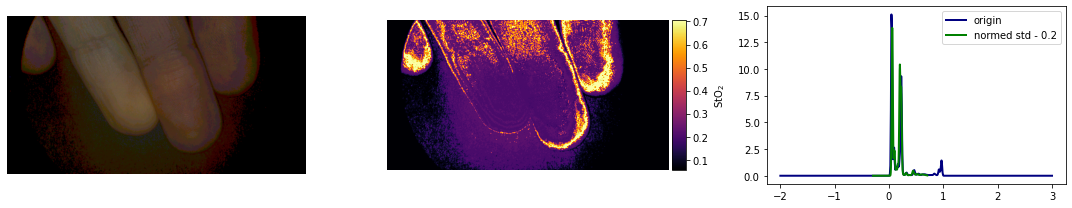

In [10]:
regressor = RandomForestRegressor(max_depth=6, random_state=0, criterion='absolute_error')
regressor.fit(train_x, train_y)

pred_y = regressor.predict(data)
output = pred_y.reshape(shape[1], shape[2])[:, :, None]
output = torch.tensor(output)

save_name = None
show_inn_combo_norm(hsi_origin, output, mask=False, save_name=save_name)

/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


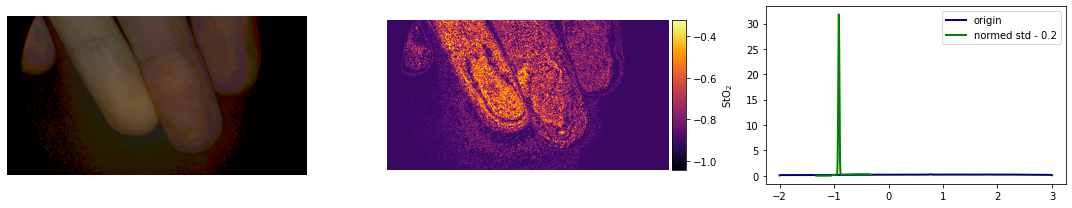

In [11]:
regressor = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5, max_iter=50000))
regressor.fit(train_x, train_y)

pred_y = regressor.predict(data)
output = pred_y.reshape(shape[1], shape[2])[:, :, None]
output = torch.tensor(output)

save_name = None
show_inn_combo_norm(hsi_origin, output, mask=False, save_name=save_name)

/Users/phinease/miniconda3/envs/hvs/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


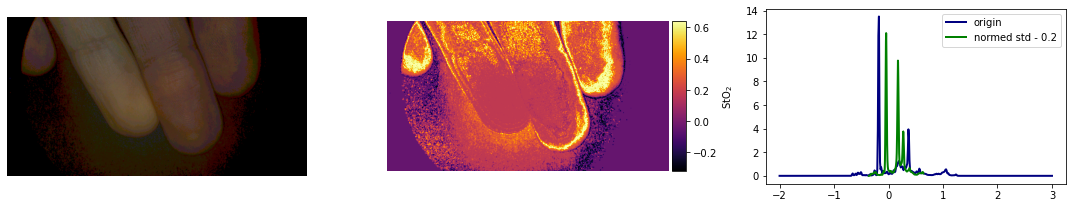

In [12]:
regressor = GradientBoostingRegressor(random_state=0)
regressor.fit(train_x, train_y)

pred_y = regressor.predict(data)
output = pred_y.reshape(shape[1], shape[2])[:, :, None]
output = torch.tensor(output)

save_name = None
show_inn_combo_norm(hsi_origin, output, mask=False, save_name=save_name)